In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinitionML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 121)
Label(s) Data rows: 13
Boolean(s) Data rows: 9
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 79
Numeric(s) Data rows: 18


### User Function(s):

In [4]:
def percentageNull(datadf):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (datadf.count() / len(datadf) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = datadf.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn
    
    
def removeColumn(datadf, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {datadf.shape[0]:,} & columns: {datadf.shape[1]:,}")
    
    # remove column
    datadf.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    datadf.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {datadf.shape[0]:,} & columns: {datadf.shape[1]:,}")

    return datadf


def removeRowUsingMask(datadf, removeColLst, colstr):
    # boolean mask
    mask = ~datadf[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    datadf = datadf[mask]
    
    # reset the index if needed
    datadf = datadf.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return datadf


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric

### User Function(s)

In [5]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

def classifier_metrics(model, Xdata, ydata, flag=None):
    """
    Classification metric for Project includes 
    Model metrics & Confusion Matrix.
    """
    # Predictions
    pred = model.predict(Xdata)
    
    # Create confusion matrix
    cm = metrics.confusion_matrix(ydata, pred, labels=model.classes_)
    
    # Initialize variables
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    Acc = (TP + TN) / (TP + TN + FP + FN)

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    
    AvgPrec = metrics.average_precision_score(ydata, pred)
        
    # Print messages
    if flag:
        print("*" * 5 + " Classification Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classification Metrics for Training:")
        
    # Classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(ydata, pred, zero_division=0))

    # Calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(ydata, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot confusion matrix and ROC curve in a single figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'], cbar=False, ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    if flag:
        ax1.set_title("Validation/Test Confusion Matrix")
    else:
        ax1.set_title("Training Confusion Matrix")

    # Plot ROC curve
    ax2.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    # Show the combined plot
    plt.tight_layout()
    plt.show()
    
    return Spec, Recall, Acc, Prec, F1Score, AvgPrec, roc_auc


def plotFeatureImportance(model, Xdata, Xcolumn, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=Xcolumn.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()

    return data


def metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'Accuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, A, R, F, AP, P, S, Auc]

    return data


def metricsClassifier(model, Xdata, ydata, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    S, R, A, P, F, AP, Auc = classifier_metrics(model, Xdata, ydata, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, S, R, A, P, F, AP, Auc)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data

In [6]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [7]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [8]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric)

# features names to list
boolCol = df_bool.boolean.to_list()
nominalCol = df_nominal.nominal.to_list()
ordinalCol = df_ordinal.ordinal.to_list()
numericCol = df_numeric.numeric.to_list()

Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 121
Total rows after: 14,856 & columns: 109


In [9]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Boolean(s) Data rows: {len(boolCol)}")
print(f"Ordinal(s) Data rows: {len(ordinalCol)}")
print(f"Nominal(s) Data rows: {len(nominalCol)}")
print(f"Numeric(s) Data rows: {len(numericCol)}")
print("\nTotal Length of Features:", len(boolCol) + len(ordinalCol) + len(nominalCol) + len(numericCol))

Orginal Data file Shape: (14856, 109)
Boolean(s) Data rows: 8
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 70
Numeric(s) Data rows: 16

Total Length of Features: 109


#### Encode

In [10]:
print(sorted(nominalCol))

['AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'Biopsy_DON', 'Bronchoscopy_DON_Combined', 'CMVStatusAtTransplant_CAN', 'Cancer_DON_Combined', 'CardiacArrest_DON', 'CerebrovascularDisease_CAN', 'ChestXray_DON', 'ChronicSteroidsUse_CAN', 'CigaretteHistory_DON', 'CigaretteUse_CAN', 'ClinicalInfection_DON', 'CocaineUse_DON', 'CoronaryAngiogram_DON', 'CrossMatch', 'DeathMechanism_DON', 'DeceasedRetyped_DON', 'DefibrillatorImplant_CAN', 'Diabetes_CAN', 'DiagnosisType_CAN', 'DialysisAfterList_CAN', 'Diuretics_DON', 'EpsteinBarrStatusTransplant_CAN', 'EpsteinBarr_DON_Combined', 'GraftFailed_CAN', 'HeartProcedureType_CAN', 'HeavyAlcoholUse_DON', 'HeparinManagement_DON', 'Hepatitis_B_CoreAntibody_CAN', 'Hepatitis_B_CoreAntibody_DON', 'Hypertension_DON', 'InfectionTherapyIV_CAN', 'InotropicMedication_DON', 'InsulinManagement_DON', 'IntropesVasodilators_CAN_Combined', 'LV_EjectionFractionMedthod_DON', '

In [11]:
df[nominalCol].head()

,Transfusion_CAN,Result_RPR_VDRL_DON,SerologyAntiCMV_DON,ArginnieManagement_DON,GraftFailed_CAN,Diuretics_DON,HeartProcedureType_CAN,InfectionTherapyIV_CAN,EpsteinBarrStatusTransplant_CAN,Thyroxine_T4_DON,AntibodyResultHBSAB_DON,CardiacArrest_DON,Antibody_HEP_C_DON,LV_EjectionFractionMedthod_DON,SurfaceAntigenHEP_B_CAN,AtTransplantSurfaceHBVAntibodyTotal_CAN,Hepatitis_B_CoreAntibody_DON,Hepatitis_B_CoreAntibody_CAN,DiagnosisType_CAN,TransplantSerostatusHIV_CAN,SurfaceAntigenHEP_B_DON,Triiodothyronine_T3_DON,CocaineUse_DON,PanelReactiveAntibody_CPRA_CAN,PastOtherDrugUse_DON,HeavyAlcoholUse_DON,SteroidsUse_DON,CerebrovascularDisease_CAN,Tatoos_DON,PastCocaineUse_DON,Diabetes_CAN,CigaretteUse_CAN,OtherDrugUse_DON,Biopsy_DON,ChronicSteroidsUse_CAN,SerostatusStatus_HEP_C_CAN,HeparinManagement_DON,InsulinManagement_DON,ClinicalInfection_DON,CMVStatusAtTransplant_CAN,NonHeartBeating_DON,UrinePortein_DON,DefibrillatorImplant_CAN,DeathMechanism_DON,TransfusionNumber_DON,SynthicAntiDiureticHormone_DON,Vasodilator_DON,InotropicMedication_DON,PriorCardiacSurgery_CAN,DeceasedRetyped_DON,CoronaryAngiogram_DON,PriorLungSurgery_CAN,PulmCath_DON,OtherInfectionSource_DON,Antihypertensive_DON,RiskHIV_DON,CrossMatch,MyocardialInfarction_DON,Hypertension_DON,PreviousMalignancy_CAN,CigaretteHistory_DON,DialysisAfterList_CAN,ChestXray_DON,Bronchoscopy_DON_Combined,Cancer_DON_Combined,EpsteinBarr_DON_Combined,IntropesVasodilators_CAN_Combined,LifeSupport_CAN_Combined,PreTranspantNAT_CAN_Combined,ResultNAT_DON_Combined
0,Y,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Low Sensitization,Y,N,Y,N,Y,N,Yes,Y,Y,Needle,N,Negative,Y,N,Y,Positive,N,N,Y,GUNSHOT WOUND,NONE,N,N,N,N,N,Unknown,N,N,0,N,N,Y,N,N,N,N,N,Abnormal,Abnormal,No,Positive,No,Yes,Unknown,Negative
1,N,Negative,Positive,N,1,Y,Orthotopic Traditional,Y,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,N,Some Sensitization,N,N,Y,N,Y,Y,No,N,U,Needle,N,Negative,N,Y,Y,Positive,N,N,Y,CARDIOVASCULAR,NONE,N,Y,N,N,N,Normal,N,N,0,Y,N,Y,N,N,N,N,N,Normal,Normal,No,Positive,No,Yes,Unknown,Negative
2,N,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,N,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Some Sensitization,N,N,Y,N,N,N,No,N,U,Needle,N,Negative,Y,Y,Y,Positive,N,N,Y,DRUG INTOXICATION,1 - 5,N,Y,N,Y,Y,Normal,N,N,0,Y,N,Y,N,N,N,N,N,Abnormal,Normal,No,Unknown,No,Yes,Unknown,Negative
3,N,Negative,Positive,N,1,Y,Orthotopic Bicaval,N,Positive,Y,Negative,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,Unknown,N,N,Y,N,N,N,No,Y,U,Needle,N,Negative,Y,Y,Y,Positive,N,Y,Y,INTRACRANIAL HEMORRHAGE/STROKE,6 - 10,N,N,Y,N,Y,Normal,N,N,0,N,N,Y,N,Y,N,N,N,Abnormal,Unknown,No,Positive,Yes,Yes,Unknown,Negative
4,N,Negative,Positive,Y,0,Y,Orthotopic Bicaval,N,Positive,Y,Unknown,N,Negative,Echo,Negative,Negative,Negative,Negative,DILATED MYOPATHY,Negative,Negative,N,U,No Sensitization,N,N,Y,N,N,N,No,Y,U,Needle,N,Negative,Y,N,Y,Negative,N,N,N,INTRACRANIAL HEMORRHAGE/STROKE,NONE,N,Y,N,Y,N,Unknown,N,N,0,Y,N,Y,N,N,N,N,N,Abnormal,Unknown,No,Positive,No,Yes,Unknown,Negative


In [12]:
# display label
df.GraftFailed_CAN.value_counts(dropna=False)

GraftFailed_CAN
0    12956
1     1900
Name: count, dtype: int64

#### Split Testing & Validation & Training

In [13]:
# split test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def EncodeDummyTrainValTest(data, labelTxt, nominalColumns, numericColumns, seed=RANDOM_STATE):

    # remove label column from nominalColumns if it exists
    if labelTxt in nominalColumns:
        # remove label
        nominalColumns.remove(labelTxt)

    # dummy Encoding
    df_encoded = pd.get_dummies(data, columns=nominalColumns, drop_first=True)

    # entire features
    X = df_encoded.drop(labelTxt, axis=1)
    y = df_encoded[labelTxt]
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

    # initialize scaling
    scaler = MinMaxScaler()

    # fit model
    fit = scaler.fit(X_train[numericColumns])

    # transform
    X_train[numericColumns] = fit.transform(X_train[numericColumns])
    X_val[numericColumns] = fit.transform(X_val[numericColumns])
    X_test[numericColumns] = fit.transform(X_test[numericColumns])
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

#### Split Train & Validation & Test

In [14]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyTrainValTest(df, 'GraftFailed_CAN', nominalCol, numericCol, RANDOM_STATE)

Training Dependent Shape: (9507, 204) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 204) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 204) & Label Shape: (2972,)


In [15]:
# find all boolean columns
boolean_columns = X_train.select_dtypes(include=bool).columns

# convert boolean to int
X_train[boolean_columns] = X_train[boolean_columns].astype(int)
X_val[boolean_columns] = X_val[boolean_columns].astype(int)
X_test[boolean_columns] = X_test[boolean_columns].astype(int)

#### SelectKBest & f_classif

In [16]:
# import libraries
from sklearn.feature_selection import SelectKBest, f_classif, chi2, VarianceThreshold

def selectKClassif(Xdata, ydata, K='all', function='f_classif'):

    # remove constant features
    constanFilter = VarianceThreshold(threshold=0)  # removes features with zero variance
    X_data = constanFilter.fit_transform(Xdata)

    # update feature names after removing constant features
    remaining_feature_names = Xdata.columns[constanFilter.get_support(indices=True)]
    
    # Step 3: Apply SelectKBest with F-classif
    selector = SelectKBest(score_func=eval(function), k=K)
    X_new = selector.fit_transform(X_data, ydata)

    # update feature names to reflect remaining, selected features
    selected_List = [remaining_feature_names[i] for i in selector.get_support(indices=True)]
    
    # create a DataFrame with selected features and their F-scores
    feature_scores = selector.scores_

    # access the p-values
    p_values = selector.pvalues_

    # create DataFrame
    feature_scores_df = pd.DataFrame({
        'Feature': remaining_feature_names,
        'Score': feature_scores,
        'p_value': p_values
    }).sort_values(by='Score', ascending=False)

    # get ONLY selected Features
    DF_selected = feature_scores_df[feature_scores_df.Feature.isin(selected_List)]
    
    # retrun
    return DF_selected, selected_List

#### Numerical Features

In [17]:
# get SelectKBest K='all' & function='f_classif' for numerical
selectedDF, selected = selectKClassif(X_train[numericCol], y_train, K='all', function='f_classif')

# p_value < .05 ONLY
NumFeatures = selectedDF.Feature[selectedDF.p_value < .05].to_list()

# display
selectedDF[selectedDF.p_value < .05]

,Feature,Score,p_value
12,TotalBilirubin_Addition,39.507493,3.411594e-10
8,TotalDayWaitList_CAN,17.393055,3.066343e-05
10,Creatinine_Difference,10.090591,1.495048e-03
11,HeightCm_Difference,8.398479,3.763934e-03
7,IschemicTimeHours_DON,7.605542,5.830032e-03
6,DistanceFrom_HospitaltoTXCenter,5.717707,1.681398e-02
5,BloodUreaNitrogenLevel_DON,5.603333,1.794626e-02
2,BloodPH_DON,3.960811,4.659985e-02


#### Categorical Features

In [18]:
# get SelectKBest K='all' & function='chi2' for categorical
selectedDF, selected = selectKClassif(X_train[list(set(X_train.columns.to_list()) - set(numericCol))], y_train, K='all', function='chi2')

# p_value < .05 ONLY
CatFeatures = selectedDF.Feature[selectedDF.p_value < .05].to_list()

# display
selectedDF[selectedDF.p_value < .05]

,Feature,Score,p_value
164,Transfusion_CAN_Y,30.878492,2.746993e-08
169,PriorCardiacSurgery_CAN_Y,26.447926,2.707390e-07
32,DialysisAfterList_CAN_Y,25.715063,3.957262e-07
181,Total_AntigensDR_CAN,24.644864,6.892821e-07
5,Total_AntigenHLA,21.330529,3.865266e-06
158,AntigenDQ1_DQ2_CAN_Addition,20.278760,6.693961e-06
93,Diabetes_CAN_Yes,18.065095,2.134793e-05
3,DiagnosisType_CAN_CONGENITAL HEART DEFECT,15.449064,8.475889e-05
104,Ventilator_CAN,12.625897,3.804392e-04
94,DiagnosisType_CAN_HEART RE-TX/GF,9.581809,1.965147e-03


In [19]:
# combine features
selected = CatFeatures + NumFeatures

# display
print(f"Total Features: {len(selected)}\n")

# display features
print(selected)

Total Features: 38

['Transfusion_CAN_Y', 'PriorCardiacSurgery_CAN_Y', 'DialysisAfterList_CAN_Y', 'Total_AntigensDR_CAN', 'Total_AntigenHLA', 'AntigenDQ1_DQ2_CAN_Addition', 'Diabetes_CAN_Yes', 'DiagnosisType_CAN_CONGENITAL HEART DEFECT', 'Ventilator_CAN', 'DiagnosisType_CAN_HEART RE-TX/GF', 'InfectionTherapyIV_CAN_Y', 'DeathMechanism_DON_DRUG INTOXICATION', 'EpsteinBarrStatusTransplant_CAN_Unknown', 'AntigenC1_C2_CAN_Addition', 'PanelReactiveAntibody_CPRA_CAN_High Sensitization', 'MismatchLevel_HLA', 'Hepatitis_B_CoreAntibody_CAN_Unknown', 'Hypertension_DON_Y', 'IntropesVasodilators_CAN_Combined_Unknown', 'Thyroxine_T4_DON_Y', 'KidneyAllocation_DON', 'MyocardialInfarction_DON_Y', 'DiagnosisType_CAN_HYPERTROPHIC CARDIOMYOPATHY', 'PreviousMalignancy_CAN_Y', 'PanelReactiveAntibody_CPRA_CAN_Unknown', 'Hepatitis_B_CoreAntibody_CAN_Positive', 'PastCocaineUse_DON_U', 'PreviousTransplantNumber_CAN', 'ChestXray_DON_Unknown', 'PriorCardiacSurgery_CAN_U', 'TotalBilirubin_Addition', 'TotalDayWaitL

In [20]:
# This function from sklearn.utils.class_weight computes the weights for each class to handle imbalanced datasets.
# The 'balanced' mode adjusts weights inversely proportional to class frequencies in the input data.
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

#### Bayesian Optimization
- A probabilistic approach to hyperparameter tuning that balances exploration (trying new areas of the parameter space) and exploitation (refining known good areas). It uses models like Gaussian Processes or Tree-structured Parzen Estimators (TPE) to predict the performance of hyperparameter sets.
    - TPE is designed to handle complex search spaces, including categorical, discrete, and continuous hyperparameters.

In [21]:
# import libraries
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

def BayesianOptimize(model, Xdata, ydata, search_space, custom_scorer,  nIter=64, nSplit=10, seed=RANDOM_STATE):


    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    kfold = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=seed)
    
    # perform Bayesian Optimization with the custom scorer
    opt = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=nIter, cv=kfold, n_jobs=-1, scoring=custom_scorer)
    BayesianOpt = opt.fit(Xdata, ydata)
    
    # best model
    Bestmodel = BayesianOpt.best_estimator_
    
    # print the best parameters and best score
    print("Best parameters found: ", BayesianOpt.best_params_)
    print("Best accuracy score: ", BayesianOpt.best_score_)
    
    # display model
    print("\nCurrent Model Parameters:")
    print("\n", Bestmodel)

    return Bestmodel


# custom scoring function
def class_specific_metrics(y_true, y_pred, target_class):
    """
    Computes class-specific precision, recall, and F1 score for a given target class.
    
    Parameters:
    - y_true: Ground truth labels (array-like)
    - y_pred: Predicted labels (array-like)
    - target_class: The specific class for which to compute the metrics for the minority class)
    
    Returns:
    - A dictionary containing class-specific metrics
    """
    precision = metrics.precision_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    recall = metrics.recall_score(y_true, y_pred, pos_label=target_class)
    f1 = metrics.f1_score(y_true, y_pred, pos_label=target_class)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# using a specific Class 1
target_class = 1
custom_scorer = metrics.make_scorer(
    lambda y_true, y_pred: class_specific_metrics(y_true, y_pred, target_class)["f1_score"], 
    greater_is_better=True
)

#### Addtional Function(s)

In [22]:
def ClassificationMatric(Algorithm, Model, Desc, model, Xdata, ydata, Type, metricDF=None):
    # determine training or validation/test
    if Type.lower() == 'training':
        flag = False
    else:
        flag = True

    # capitalize
    Type = Type.capitalize()
        
    # display report - training
    Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, Xdata, ydata, flag=flag)
    
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, Accuracy, Precision, F1, AveragePrecision, AUC)

    # check existing DataFrame
    if metricDF is not None and not metricDF.empty:
        # concat two dataframes
        dfNew = pd.concat([metricDF, df_metrics], ignore_index=True)

        # reset the index
        dfNew.reset_index(drop=True, inplace=True)
    else:
        # copy first metrics dataframe
        dfNew = df_metrics.copy()

    return dfNew       

### Random Forest Classifier

In [23]:
# import library
from sklearn.ensemble import RandomForestClassifier

# define the search space
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(10, 75),
    'min_samples_leaf': Integer(10, 50),  
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy']) 
}

# initialize Model with class weights
rfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate Random Forest Classifier
model = RandomForestClassifier(**rfc_param)

# Bayesian Optimization
model = BayesianOptimize(model, X_train[selected], y_train, search_space, custom_scorer,  nIter=64, nSplit=10, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 19), ('min_samples_split', 10), ('n_estimators', 500)])
Best accuracy score:  0.26315860161057214

Current Model Parameters:

 RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.5733325292485828,
                                     1: 3.909128289473684},
                       max_depth=5, max_features='log2', min_samples_leaf=19,
                       min_samples_split=10, n_estimators=500,
                       random_state=1776)


                                                   % Feature Importance
TotalBilirubin_Addition                                       12.761600
PriorCardiacSurgery_CAN_Y                                     11.108668
TotalDayWaitList_CAN                                           7.201948
Transfusion_CAN_Y                                              7.008434
HeightCm_Difference                                            6.277840
Creatinine_Difference                                          6.258802
DistanceFrom_HospitaltoTXCenter                                5.958628
Diabetes_CAN_Yes                                               5.449474
IschemicTimeHours_DON                                          4.594309
DialysisAfterList_CAN_Y                                        4.054045
Total_AntigenHLA                                               3.188005
BloodUreaNitrogenLevel_DON                                     3.134416
BloodPH_DON                                                    2

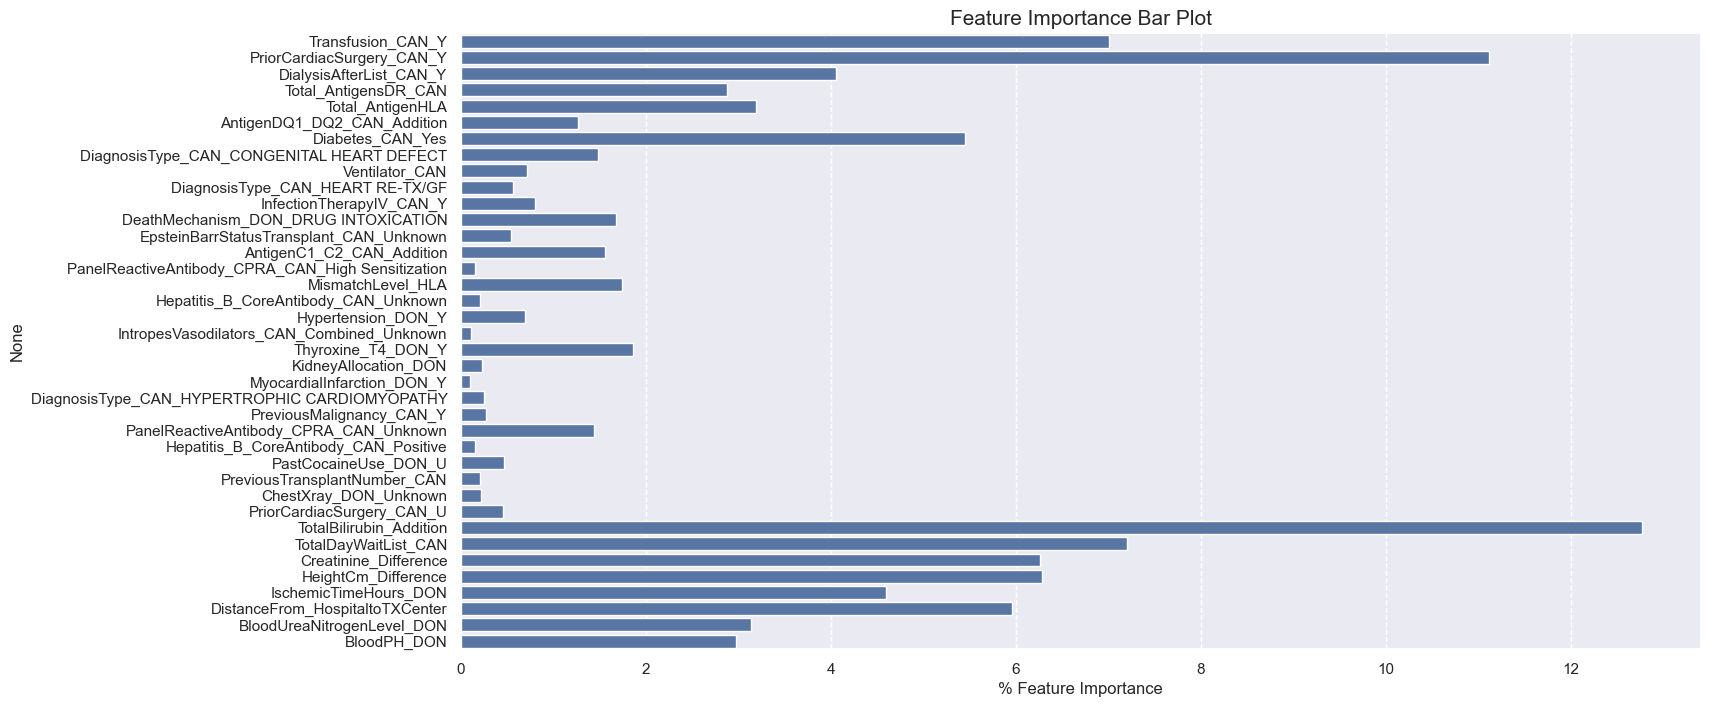

In [24]:
# plot
df_rfc = plotFeatureImportance(model, X_train[selected],X[selected], figsize=(16,8))

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      8291
           1       0.23      0.66      0.34      1216

    accuracy                           0.67      9507
   macro avg       0.58      0.66      0.56      9507
weighted avg       0.84      0.67      0.72      9507



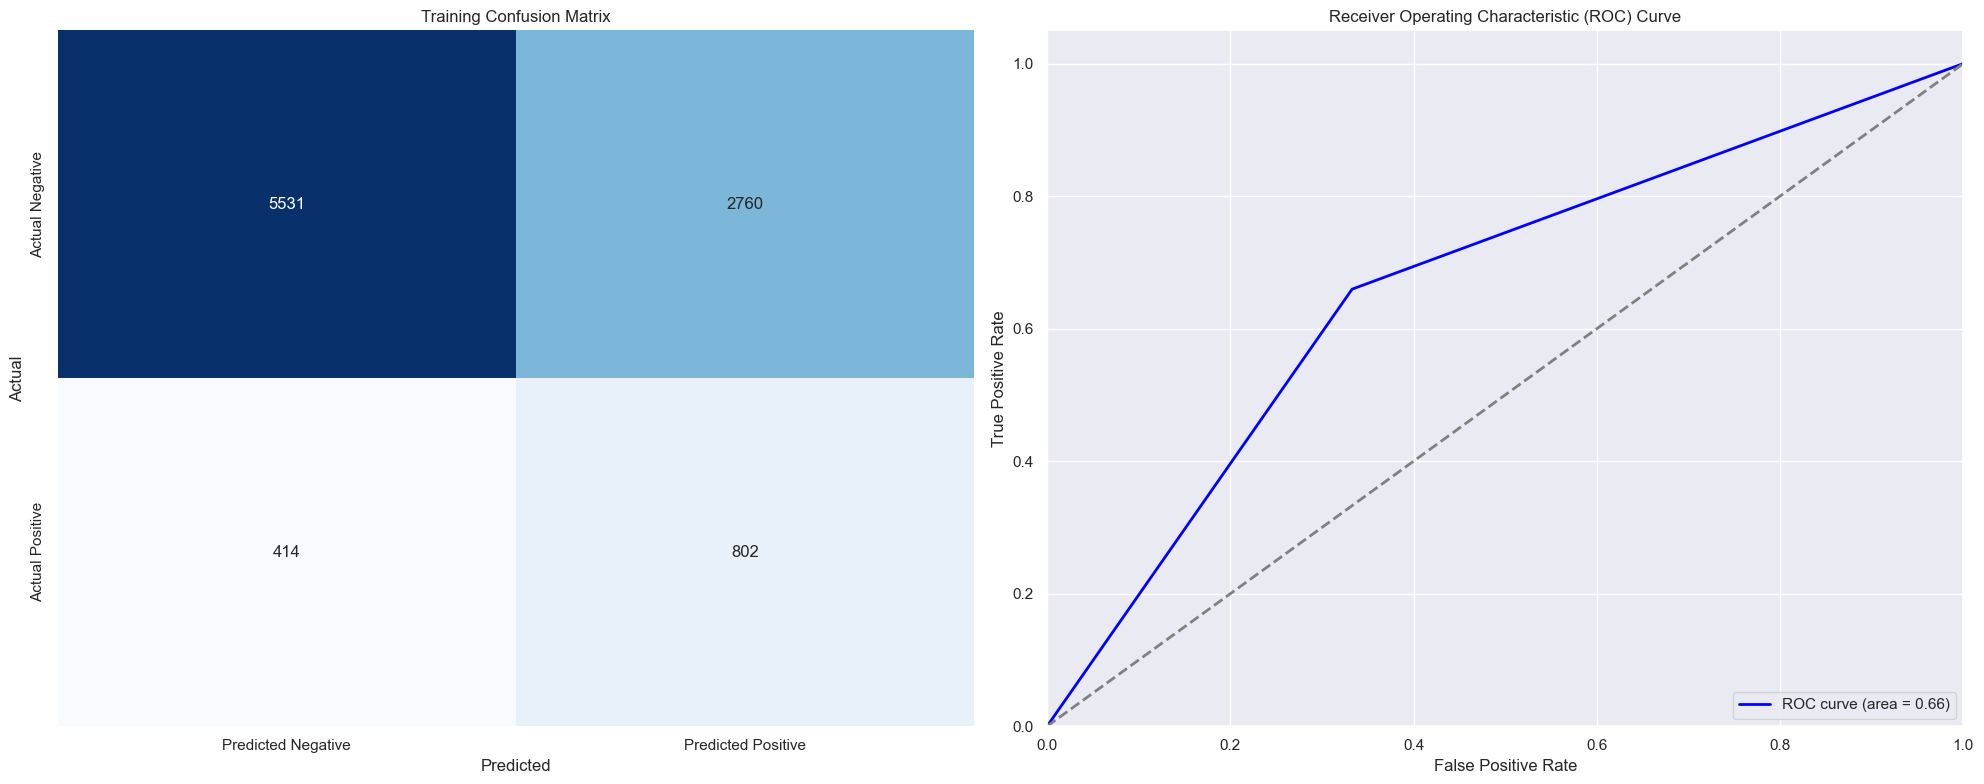

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324


In [25]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif)'
Model = 'rfc_both_fit'
Type = 'Training'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_train[selected], y_train, Type, metricDF=None)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.65      0.75      2073
           1       0.17      0.50      0.26       304

    accuracy                           0.63      2377
   macro avg       0.54      0.57      0.50      2377
weighted avg       0.81      0.63      0.69      2377



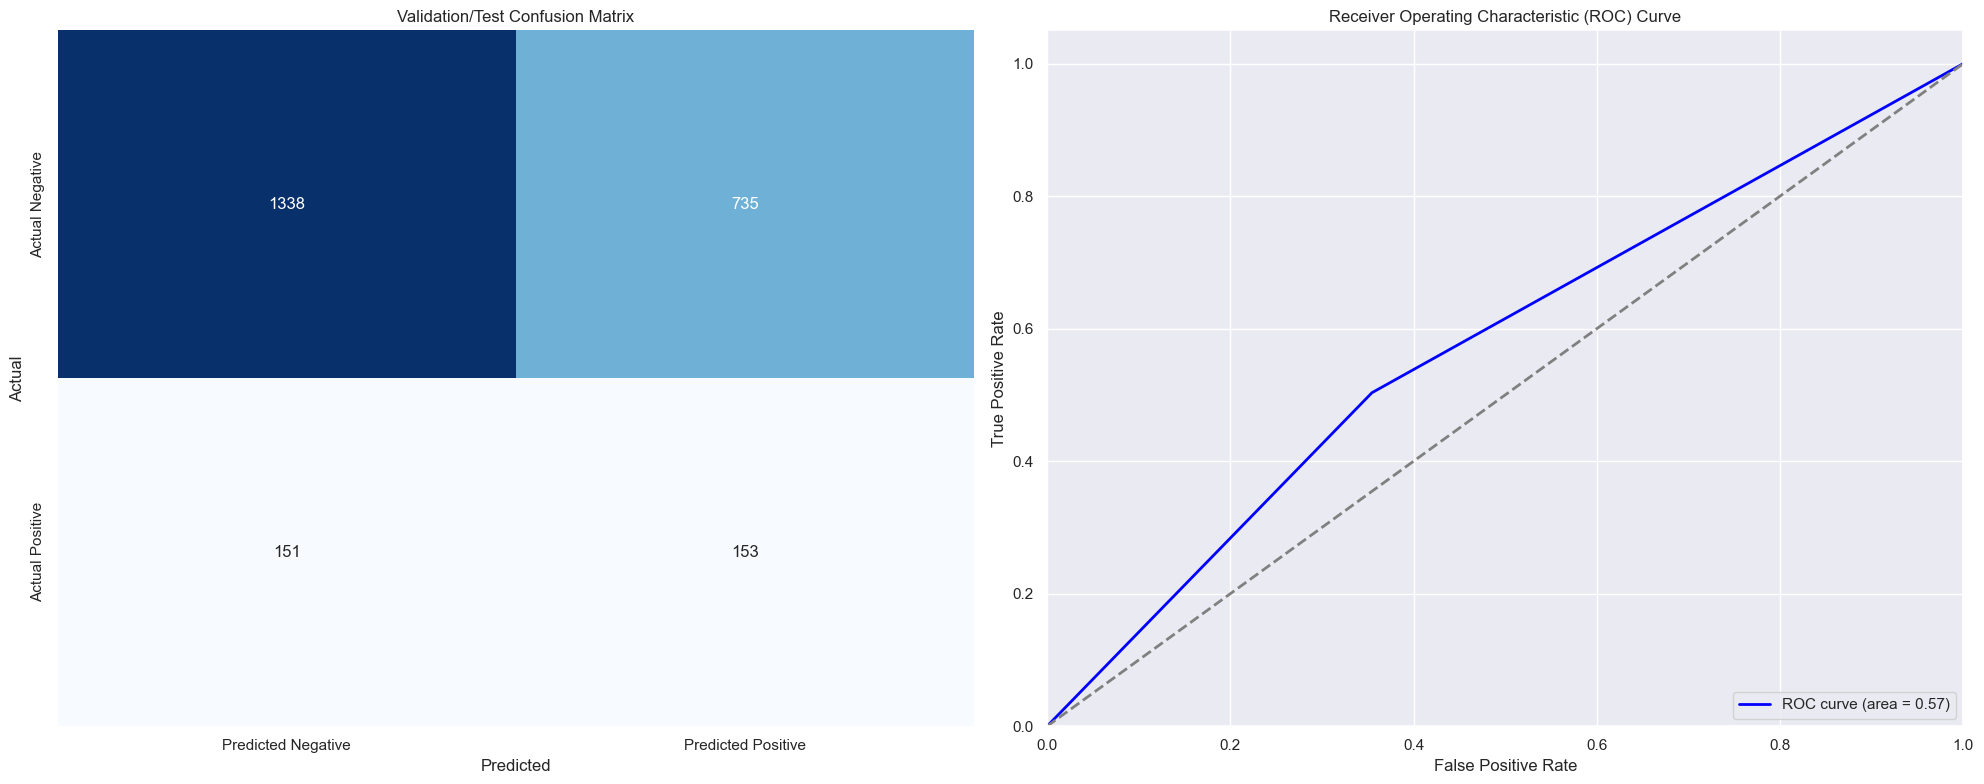

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324
1,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.627261,0.503289,0.256711,0.150241,0.172297,0.645441,0.574365


In [26]:
# initialize variables
Type = 'Validation'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_val[selected], y_val, Type, df_classfication)
df_classfication

#### XGBoost

In [27]:
# import library
from xgboost import XGBClassifier

# calculate the scale_pos_weight to adjust for class imbalance
# helps to counteract the imbalance by giving more weight to the minority class (usually the positive class in binary classification).
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# define the search space
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 50),
    'learning_rate': Real(0.05, 1.0, prior='log-uniform'),
    'subsample':  Real(0.1, 1.0, prior='log-uniform'),       # Subsample ratio
    'colsample_bytree': Real(0.3, 1.0, prior='log-uniform'), # Feature sampling ratio
    'min_child_weight': Integer(1, 50),                      # Minimum child weight
    'gamma': Real(1e-5, 0.5, prior='log-uniform')            # Minimum loss reduction
}

# initialize Model with scale_pos_weight
xgb_param = {'scale_pos_weight': scale_pos_weight, 'n_jobs': -1,'random_state': RANDOM_STATE}

# instantiate XGB Classifier
model = XGBClassifier(**xgb_param)

# Bayesian Optimization
model = BayesianOptimize(model, X_train[selected], y_train, search_space, custom_scorer,  nIter=64, nSplit=10, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('colsample_bytree', 0.3), ('gamma', 0.49999999999999994), ('learning_rate', 0.05), ('max_depth', 5), ('min_child_weight', 50), ('n_estimators', 50), ('subsample', 0.38671829965661597)])
Best accuracy score:  0.26294321699473094

Current Model Parameters:

 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.49999999999999994, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
    

                                                   % Feature Importance
PriorCardiacSurgery_CAN_Y                                      5.880915
TotalBilirubin_Addition                                        4.844867
DiagnosisType_CAN_CONGENITAL HEART DEFECT                      4.814609
ChestXray_DON_Unknown                                          4.592730
Transfusion_CAN_Y                                              4.485839
PanelReactiveAntibody_CPRA_CAN_Unknown                         4.231425
DialysisAfterList_CAN_Y                                        4.221638
DeathMechanism_DON_DRUG INTOXICATION                           4.105165
PreviousMalignancy_CAN_Y                                       3.908377
EpsteinBarrStatusTransplant_CAN_Unknown                        3.725678
Diabetes_CAN_Yes                                               3.659767
TotalDayWaitList_CAN                                           3.441423
Total_AntigensDR_CAN                                           3

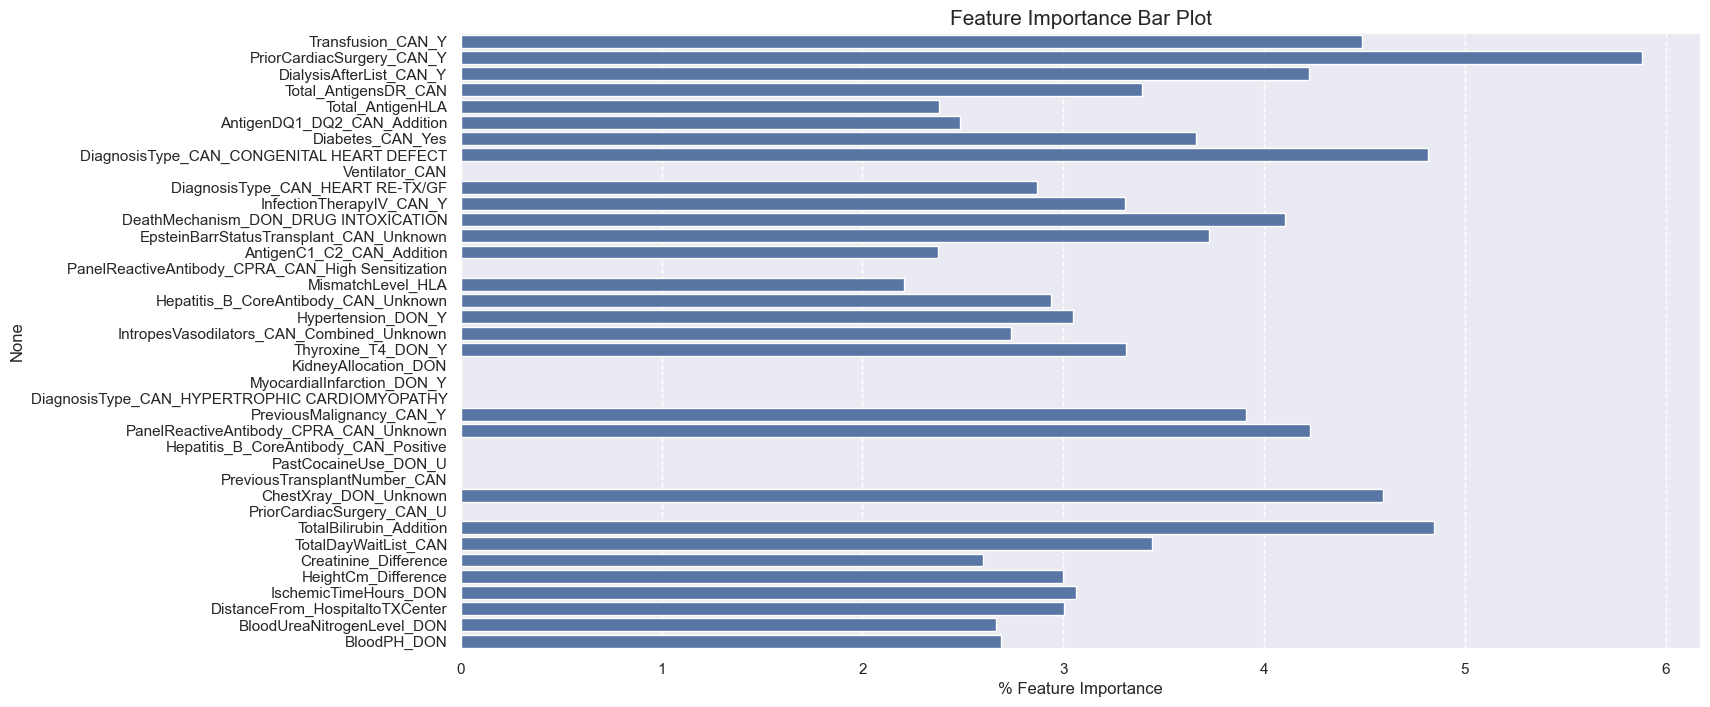

In [28]:
# plot
df_xgb = plotFeatureImportance(model, X_train[selected],X[selected], figsize=(16,8))

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78      8291
           1       0.22      0.61      0.32      1216

    accuracy                           0.67      9507
   macro avg       0.57      0.64      0.55      9507
weighted avg       0.83      0.67      0.72      9507



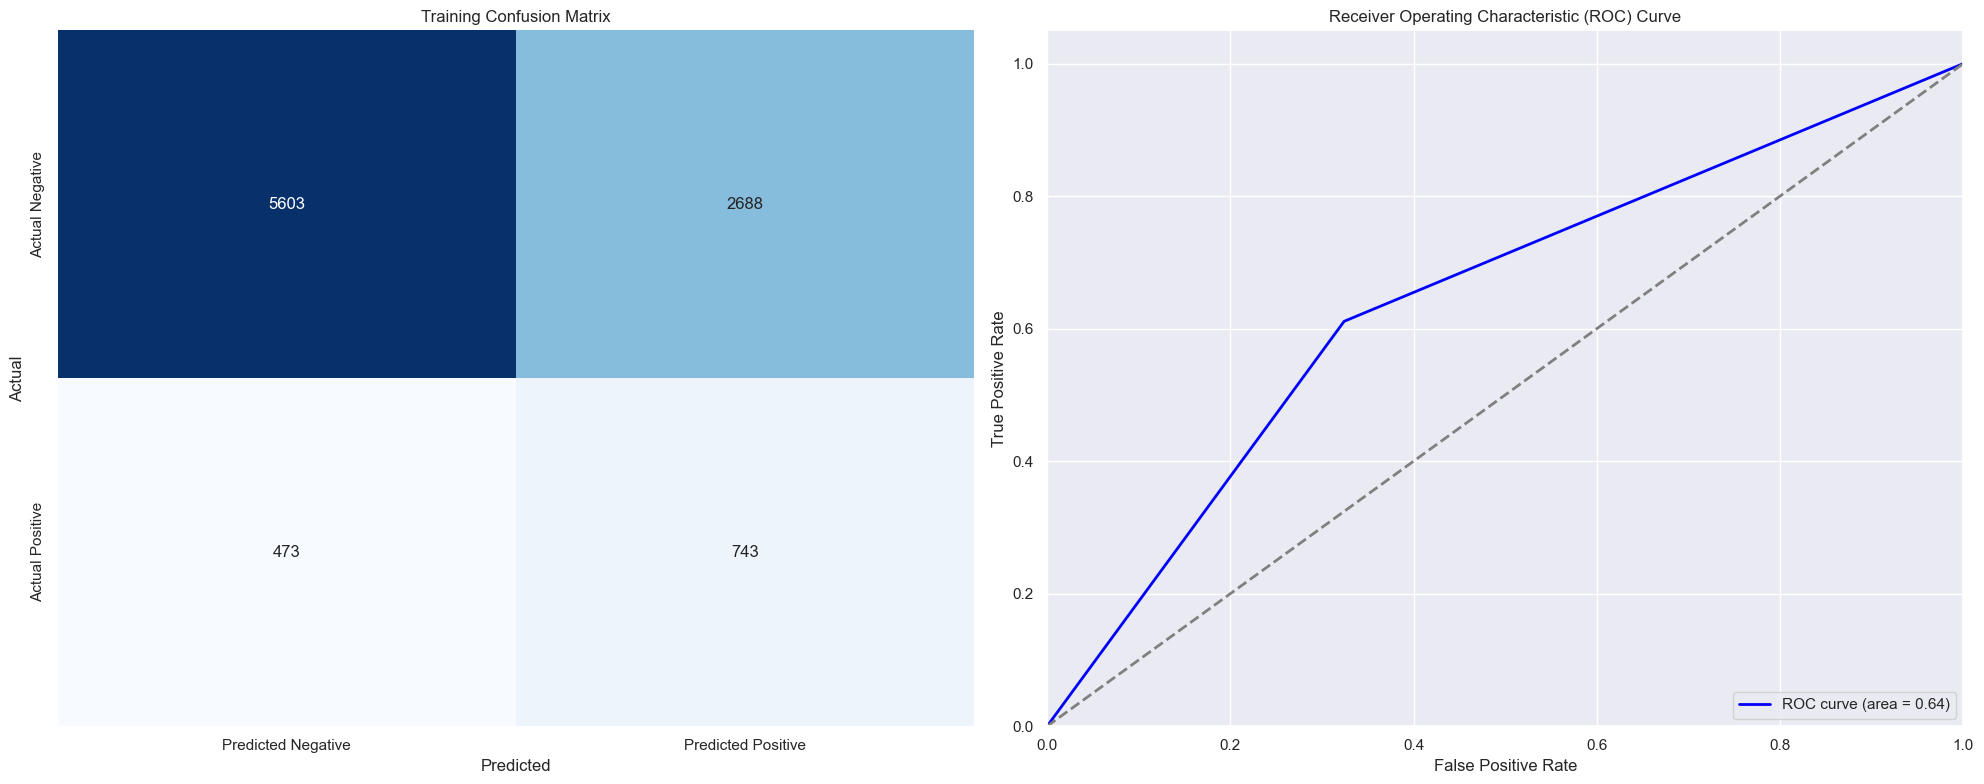

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324
1,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.627261,0.503289,0.256711,0.150241,0.172297,0.645441,0.574365
2,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.667508,0.611020,0.319776,0.182072,0.216555,0.675793,0.643406


In [29]:
# initialize variables
Algorithm = 'XGBoostClassifier'
Desc = 'XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif)'
Model = 'xgb_both_fit'
Type = 'Training'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_train[selected], y_train, Type, df_classfication)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.67      0.77      2073
           1       0.18      0.51      0.27       304

    accuracy                           0.64      2377
   macro avg       0.54      0.59      0.52      2377
weighted avg       0.81      0.64      0.70      2377



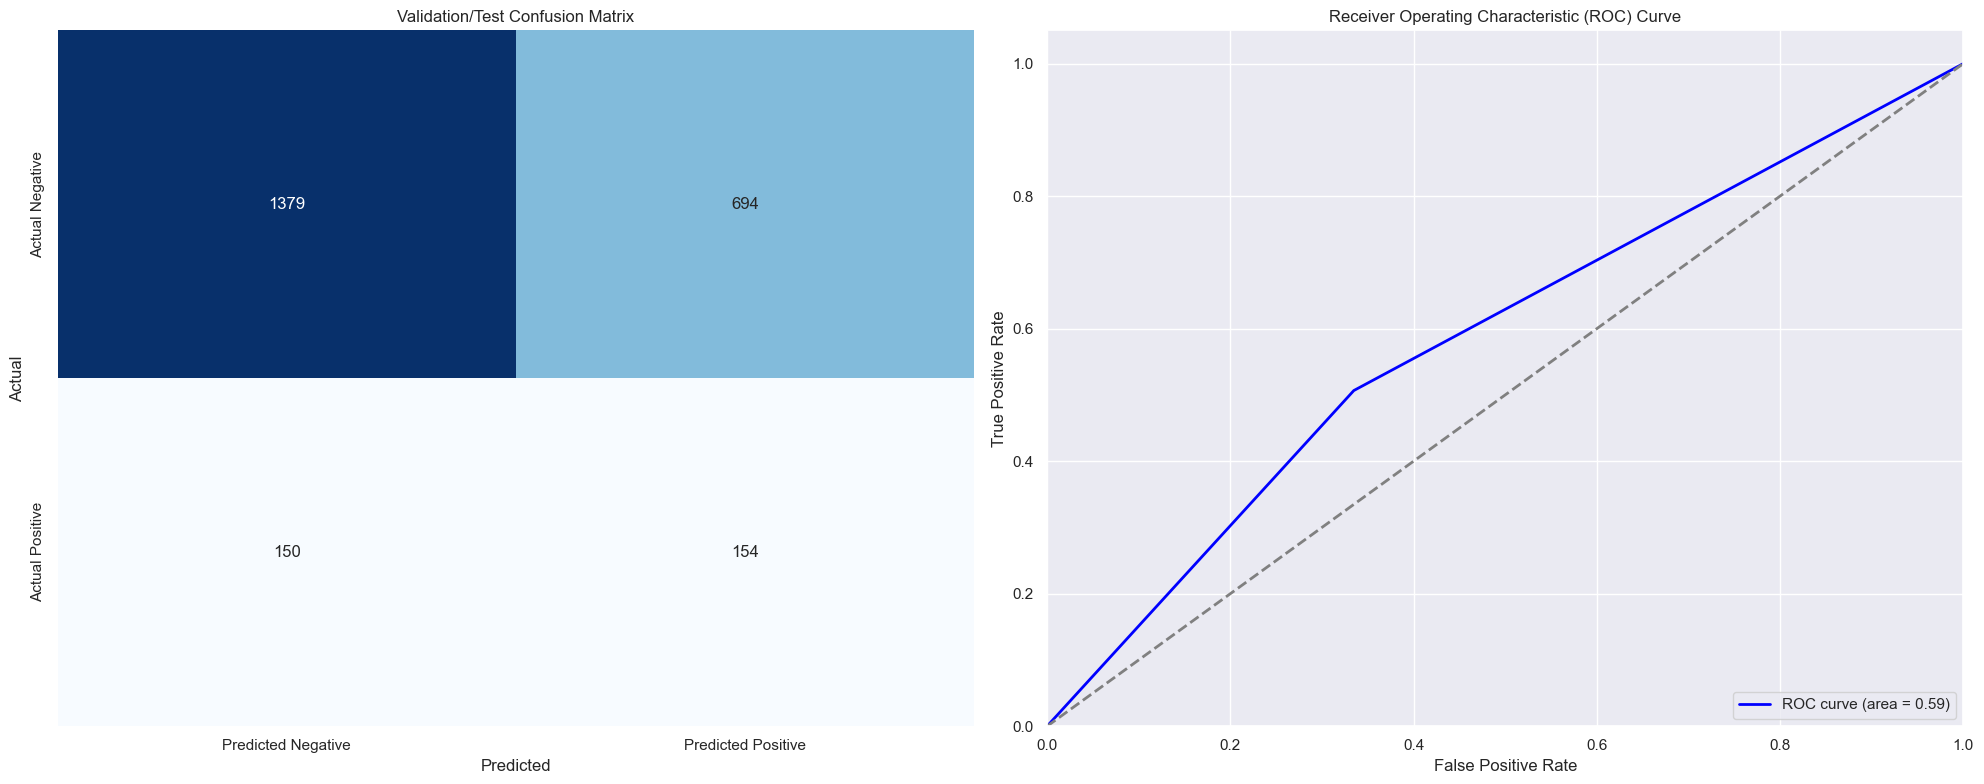

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324
1,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.627261,0.503289,0.256711,0.150241,0.172297,0.645441,0.574365
2,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.667508,0.611020,0.319776,0.182072,0.216555,0.675793,0.643406
3,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.644931,0.506579,0.267361,0.155101,0.181604,0.665219,0.585899


In [30]:
# initialize variables
Type = 'Validation'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_val[selected], y_val, Type, df_classfication)
df_classfication

### Logistic Regression

In [31]:
# import library
from sklearn.linear_model import LogisticRegression

# define the parameter search space
search_space = {
    'C': Real(0.01, 50, prior='log-uniform')
}

# Base Model
lrc_param = {'max_iter':10000, 'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
model = LogisticRegression(**lrc_param)

# Bayesian Optimization
model = BayesianOptimize(model, X_train[selected], y_train, search_space, custom_scorer,  nIter=64, nSplit=10, seed=RANDOM_STATE)

Best parameters found:  OrderedDict([('C', 4.532496707826017)])
Best accuracy score:  0.27269074592210013

Current Model Parameters:

 LogisticRegression(C=4.532496707826017,
                   class_weight={0: 0.5733325292485828, 1: 3.909128289473684},
                   max_iter=10000, random_state=1776)


***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.62      0.74      8291
           1       0.19      0.59      0.28      1216

    accuracy                           0.62      9507
   macro avg       0.55      0.61      0.51      9507
weighted avg       0.82      0.62      0.68      9507



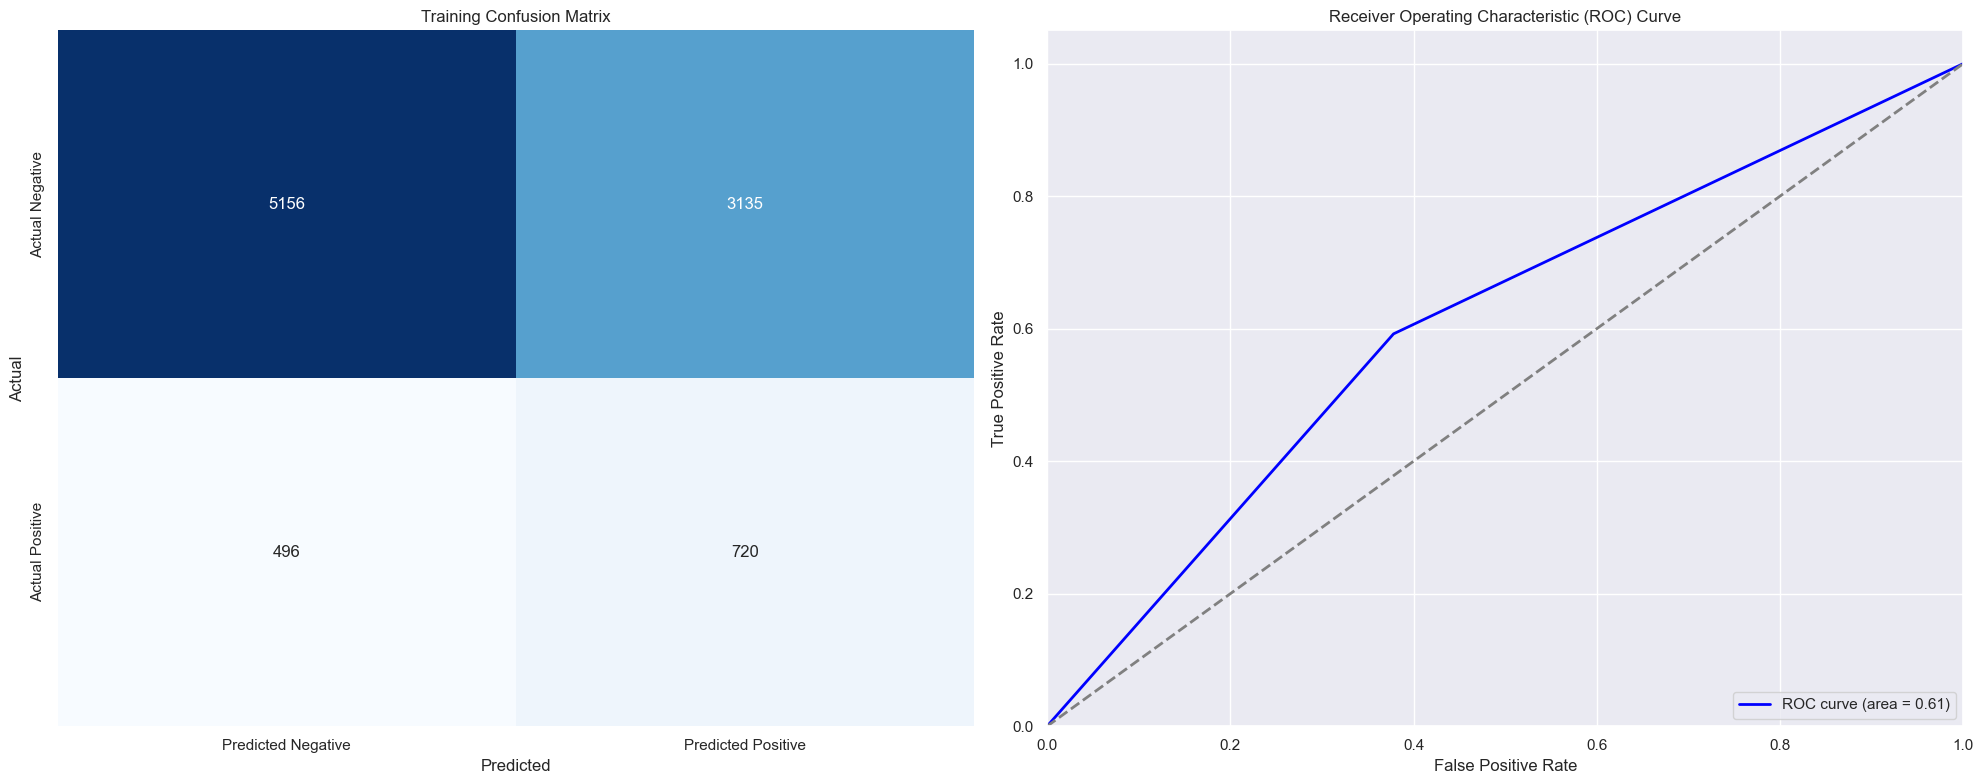

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324
1,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.627261,0.503289,0.256711,0.150241,0.172297,0.645441,0.574365
2,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.667508,0.611020,0.319776,0.182072,0.216555,0.675793,0.643406
3,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.644931,0.506579,0.267361,0.155101,0.181604,0.665219,0.585899
4,LogisticRegression,lrc_both_fit,LogisticRegression - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.618071,0.592105,0.283968,0.162760,0.186770,0.621879,0.606992


In [32]:
# initialize variables
Algorithm = 'LogisticRegression'
Desc = 'LogisticRegression - Scaled BayesSearchCV - Features Functions (chi2 & f_classif)'
Model = 'lrc_both_fit'
Type = 'Training'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_train[selected], y_train, Type, df_classfication)
df_classfication

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.62      0.73      2073
           1       0.16      0.51      0.25       304

    accuracy                           0.60      2377
   macro avg       0.53      0.56      0.49      2377
weighted avg       0.80      0.60      0.67      2377



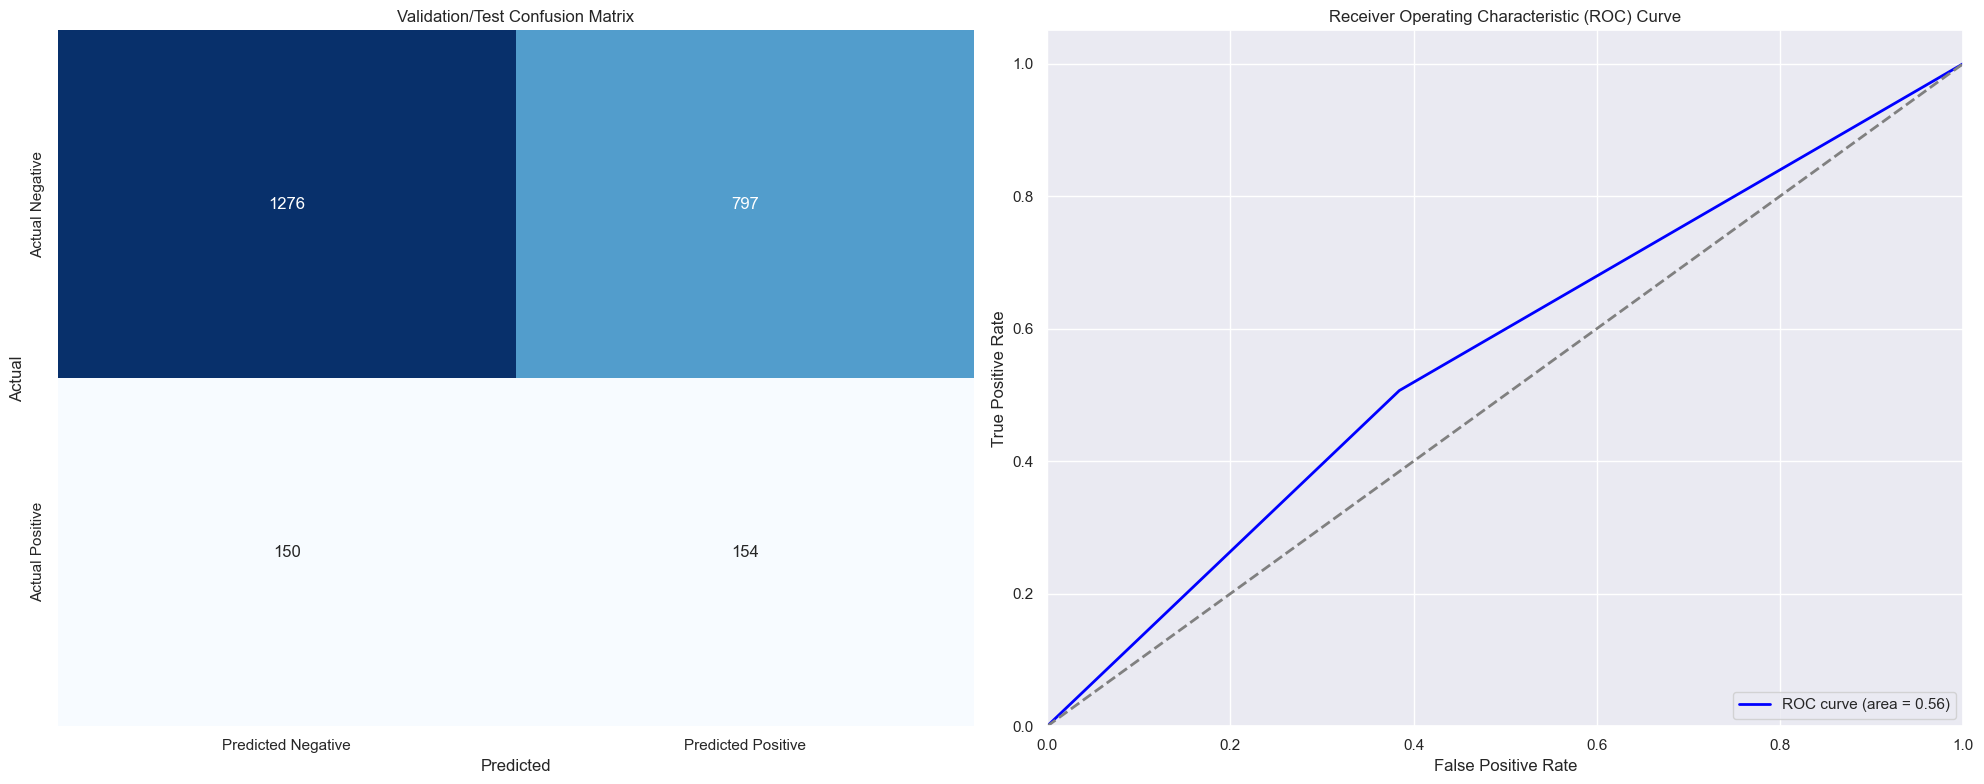

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.666141,0.659539,0.335705,0.192045,0.225154,0.667109,0.663324
1,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.627261,0.503289,0.256711,0.150241,0.172297,0.645441,0.574365
2,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.667508,0.611020,0.319776,0.182072,0.216555,0.675793,0.643406
3,XGBoostClassifier,xgb_both_fit,XGBoostClassifier - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.644931,0.506579,0.267361,0.155101,0.181604,0.665219,0.585899
4,LogisticRegression,lrc_both_fit,LogisticRegression - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Training,0.618071,0.592105,0.283968,0.162760,0.186770,0.621879,0.606992
5,LogisticRegression,lrc_both_fit,LogisticRegression - Scaled BayesSearchCV - Features Functions (chi2 & f_classif),Validation,0.601599,0.506579,0.245418,0.145138,0.161935,0.615533,0.561056


In [33]:
# initialize variables
Type = 'Validation'

# display
df_classfication = ClassificationMatric(Algorithm, Model, Desc, model, X_val[selected], y_val, Type, df_classfication)
df_classfication

##### Metrics
- `Accuracy` is a metric used to evaluate the performance of a classification model. It measures the proportion of correct predictions out of the total predictions made.
- `Recall`, also known as `Sensitivity` or `True Positive Rate` (TPR), is a metric used to evaluate the performance of a classification model, particularly in situations where correctly identifying positive cases
- The `F1 score` is the harmonic mean of `precision` and `recall`. It ranges from 0 to 1, where 1 indicates the best possible performance.
- `Average Precision` calculates the area under the precision-recall curve by averaging precision values at increasing recall levels.
- `Precision` is a metric used to evaluate the accuracy of positive predictions in a classification model, particularly useful in binary classification tasks. It measures how many of the instances predicted as positive are actually positive.
- `Specificity` (also known as the `True Negative Rate`) is a metric used in binary classification to measure the model’s ability to correctly identify negative instances. It tells us the proportion of actual negatives that were correctly classified as negative by the model.
- The `ROC AUC score` is a performance metric for classification models, particularly useful for evaluating models in binary classification tasks. It combines Receiver Operating Characteristic (ROC) curve analysis with the Area Under the Curve (AUC).
    -  The area under the ROC curve (AUC) provides a single value summary of the model's ability to discriminate between positive and negative classes. It ranges from 0 to 1, where:
    - AUC = 1: Perfect classifier (it perfectly separates positive and negative classes).
    - AUC = 0.5: Model has no discrimination ability (equivalent to random guessing).
    - AUC < 0.5: The model performs worse than random guessing (this suggests the model may need to be inverted or there’s an issue with the model).